<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/ReduceDimentionByPCR_PLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Principle Compoinents Regression

PCR can be performed using PCA() function in sklearn library. This lab will apply PCR to the Hitters data to predict Salary.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

df = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Hitters.csv').dropna().drop('Unnamed: 0', axis = 1)
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

Setup the data

In [3]:
y =df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)


### Perfoming PCA

In [4]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

In [8]:
# print out the first few variables of the first few principal components
pd.DataFrame(pca.components_.T).loc[:4, :5]

,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


### Using 10-fold cross-validation to asses the MSE

(-1.0, 19.95)

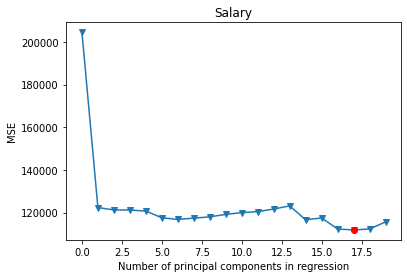

In [20]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=10)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principle components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using CV for the 19 priciple components, adding one component at the time.
for i in np.arange(1, 20):
  score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
  mse.append(score)

# Plot results
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.plot(np.argmin(mse),mse[np.argmin(mse)],'ro')
plt.title('Salary')
plt.xlim(xmin=-1)

### Variance explained by adding each consecutive principal component

In [21]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

(-1.0, 19.95)

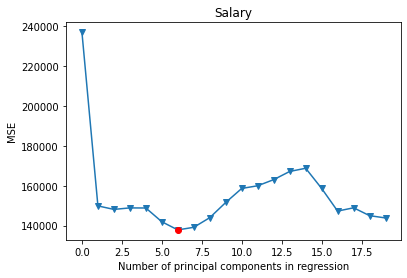

In [25]:
pca2 = PCA()

# Split into tranining and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=1)

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-flod CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse= []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring="neg_mean_squared_error").mean()
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time
for i in np.arange(1,20):
  score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring="neg_mean_squared_error").mean()
  mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.plot(np.argmin(mse),mse[np.argmin(mse)],'ro')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)


In [24]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

111994.42273636989

## Partial Least Squares

(-1.0, 19.9)

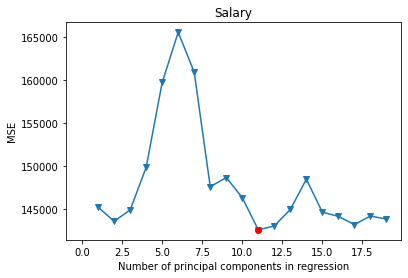

In [43]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.plot(np.argmin(mse)+1,mse[np.argmin(mse)],'ro')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)

145200.30879176184

M = 2, 11 is the lowest. Now we evaluate the corresponding test set MSE:

In [46]:

pls = PLSRegression(n_components=1)
pls.fit(scale(X_train), y_train)

print(mean_squared_error(y_test, pls.predict(scale(X_test))))


pls = PLSRegression(n_components=10)
pls.fit(scale(X_train), y_train)

print(mean_squared_error(y_test, pls.predict(scale(X_test))))

101780.51391077759
110584.60046674963
